# Land cover types

## Overview

- **Key ideas:**
    - Land cover classes for South America using `MCD12C1 MODIS version 006` product.
    - Data format is `HDF4` with spatial resolution of 0.05 x 0.05° and `annual` time steps from 2001 to 2019.
    - We regrid land cover data to the GIMMS NDVI3g 1/12 x 1/12° grid for South America and export the results (2001-2019) to a netcdf file.
    - Pixel-wise area calculation.
    - Time evolution of land cover regridded data.
- **References:**
    - [MODIS/Terra+Aqua Land Cover Type CMG Yearly L3 Global 0.05 Deg](https://lpdaac.usgs.gov/products/mcd12c1v006/). 

## Initial setup

In [1]:
# Load packages.
import os
import sys
import glob
import warnings

import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import cartopy.crs as ccrs

from matplotlib import cm
from matplotlib.colors import ListedColormap
from datetime import datetime
from dask.diagnostics import ProgressBar

# Better visualization of metadata.
xr.set_options(display_style="text")

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
print(">>> Versions:")
print("* numpy:", np.__version__)
print("* xarray:", xr.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* xarray: 0.16.0

>>> Computer:
* Hostname: n008
* User: sandroal
* Directory: /work/sandroal/notebooks/single_variables
* Date: Mon Nov  2 12:04:17 BRST 2020
* CPUs: 40


In [3]:
%%time

# My repository.
repository = "/work/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

CPU times: user 1.69 s, sys: 352 ms, total: 2.04 s
Wall time: 2.6 s


In [4]:
# Main directory.
MAIN_FOLDER = "/work/sandroal/data_sets/MODIS/LAND_COVER/"

# Map borders for South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Final results.
save_fig = True

# Data files location.
FIG_FOLDER = "/work/sandroal/images/single_variables/"

In [5]:
# One file for each year (2001 - 2018). 
FILES_PATHS = sorted(glob.glob(MAIN_FOLDER + "*hdf"))

# Show all data files paths.
FILES_PATHS

['/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2001001.006.2018053185512.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2002001.006.2018053185530.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2003001.006.2018053185458.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2004001.006.2018053182130.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2005001.006.2018053183837.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2006001.006.2018053183950.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2007001.006.2018053184448.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2008001.006.2018053184623.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2009001.006.2018053184946.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2010001.006.2018053185051.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2011001.006.2018053185321.hdf',
 '/work/sandroal/data_sets/MODIS/LAND_COVER/MCD12C1.A2012001.006.

## Load NDVI data

In [6]:
%%time

# Into memory.
DS_NDVI = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/GIMMS/ppdata_ndvi.nc"
).load()

# Show it.
print(DS_NDVI)

<xarray.Dataset>
Dimensions:    (lat: 960, lon: 720, time: 828)
Coordinates:
    land_mask  (lat, lon) bool False False False False ... False False False
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat        (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
  * time       (time) datetime64[ns] 1981-07-01 1981-07-15 ... 2015-12-15
Data variables:
    ndvi       (time, lat, lon) float32 -0.3 -0.3 -0.3 -0.3 ... -0.3 -0.3 -0.3
Attributes:
    FileName:              ndvi3g_geo_v1_1981_0712.nc4
    Institution:           NASA/GSFC GIMMS
    Data:                  NDVI3g version 1
    Reference:             1. Pinzon, J.E.; Tucker, C.J.                     ...
    CommentsVersion1:      version1 includes two major fixes (a and b), and t...
    Temporalrange:         1981-07-01 -> 2015-12-31
    Year:                  1981.0
    RangeSemester:         Jul 1 - Dec 31 (7:0.5:12.5)
    SpatialResolution:     1/12 x 1/12 degrees
    TemporalResolut

## Load and explore single land cover file

In [7]:
# Read meta data.
DS_LC = xr.open_dataset(FILES_PATHS[0])

# Show it.
print(DS_LC)

<xarray.Dataset>
Dimensions:                                (Num_IGBP_Classes:MOD12C1: 17, Num_LAI_FPAR_Classes:MOD12C1: 11, Num_UMD_Classes:MOD12C1: 16, XDim:MOD12C1: 7200, YDim:MOD12C1: 3600)
Dimensions without coordinates: Num_IGBP_Classes:MOD12C1, Num_LAI_FPAR_Classes:MOD12C1, Num_UMD_Classes:MOD12C1, XDim:MOD12C1, YDim:MOD12C1
Data variables:
    Majority_Land_Cover_Type_1             (YDim:MOD12C1, XDim:MOD12C1) float32 ...
    Majority_Land_Cover_Type_1_Assessment  (YDim:MOD12C1, XDim:MOD12C1) float32 ...
    Land_Cover_Type_1_Percent              (YDim:MOD12C1, XDim:MOD12C1, Num_IGBP_Classes:MOD12C1) float32 ...
    Majority_Land_Cover_Type_2             (YDim:MOD12C1, XDim:MOD12C1) float32 ...
    Majority_Land_Cover_Type_2_Assessment  (YDim:MOD12C1, XDim:MOD12C1) float32 ...
    Land_Cover_Type_2_Percent              (YDim:MOD12C1, XDim:MOD12C1, Num_UMD_Classes:MOD12C1) float32 ...
    Majority_Land_Cover_Type_3             (YDim:MOD12C1, XDim:MOD12C1) float32 ...
    Majorit

In [8]:
%%time

# Major class occurrence (Num_IGBP_Classes=17).
DA_LC = DS_LC.Majority_Land_Cover_Type_1
print(">>> Global data size in GB (as float):", DA_LC.nbytes / 1e9)
print("")
print(DA_LC)

>>> Global data size in GB (as float): 0.10368

<xarray.DataArray 'Majority_Land_Cover_Type_1' (YDim:MOD12C1: 3600, XDim:MOD12C1: 7200)>
[25920000 values with dtype=float32]
Dimensions without coordinates: YDim:MOD12C1, XDim:MOD12C1
Attributes:
    long_name:                           Majority_Land_Cover_Type_1
    units:                               class number
    valid_range:                         [ 0 16]
    water:                               0
    evergreen needleleaf forest:         1
    evergreen broadleaf forest:          2
    deciduous needleleaf forest:         3
    deciduous broadleaf forest:          4
    mixed forests:                       5
    closed shrubland:                    6
    open shrublands:                     7
    woody savannas:                      8
    savannas:                            9
    grasslands:                          10
    permanent wetlands:                  11
    croplands:                           12
    urban and built-up

In [9]:
%%time

# Load this data into memory as an xarray DataArray object.
DA_LC = DA_LC.astype(np.int8) # Less memory.
print(">>> Global data size in GB (as int):", DA_LC.nbytes / 1e9)
with ProgressBar():
    DA_LC = DA_LC.load()

# Coordinates as usual.    
DA_LC = DA_LC.rename({"YDim:MOD12C1": "lat", "XDim:MOD12C1": "lon"})
DA_LC = DA_LC[::-1, :] # This is trick! It couldn't work otherwise when plotting data!
DA_LC.coords["lat"] = ("lat", np.arange(-90, 90, 0.05)) # Ascending order.
DA_LC.coords["lon"] = ("lon", np.arange(-180, 180, 0.05)) # Ascending order.

# South America.
DA_LC = DA_LC.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

# Final form.
print(">>> South America data size in GB (as int):", DA_LC.nbytes / 1e9)
print("")
print(DA_LC)

>>> Global data size in GB (as int): 0.02592
>>> South America data size in GB (as int): 0.00192

<xarray.DataArray 'Majority_Land_Cover_Type_1' (lat: 1600, lon: 1200)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [8, 4, 4, ..., 0, 0, 0],
       [8, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0]], dtype=int8)
Coordinates:
  * lat      (lat) float64 -59.95 -59.9 -59.85 -59.8 ... 19.85 19.9 19.95 20.0
  * lon      (lon) float64 -90.0 -89.95 -89.9 -89.85 ... -30.15 -30.1 -30.05
CPU times: user 60 ms, sys: 92 ms, total: 152 ms
Wall time: 153 ms


In [10]:
%%time

# All land types.
classes_dict_swapped = {
    "Water":                               0,
    "Evergreen needleleaf forest":         1,
    "Evergreen broadleaf forest":          2,
    "Deciduous needleleaf forest":         3,
    "Deciduous broadleaf forest":          4,
    "Mixed forests":                       5,
    "Closed shrubland":                    6,
    "Open shrublands":                     7,
    "Woody savannas":                      8,
    "Savannas":                            9,
    "Grasslands":                          10,
    "Permanent wetlands":                  11,
    "Croplands":                           12,
    "Urban and built up":                  13,
    "Cropland natural vegetation mosaic":  14,
    "Snow and ice":                        15,
    "Barren or sparsely vegetated":        16
}  

# Swap keys and values of the previous dict.
classes_dict = dict([(value, key) for key, value in classes_dict_swapped.items()]) 

# Count ocurrences on South America.
classes, counts = np.unique(DA_LC.values.flatten(), return_counts=True)

# No occurrence for class 3 (Deciduous needleleaf forest).
classes = np.insert(classes, 3, 3)
counts = np.insert(counts, 3, 0)

# All classes percentages.
total = np.sum(counts)
percentages = counts / total * 100

# Show results.
print(">>> Total of grid points:", total)
print(">>> Code; Count; Percentage; Class")
for CLASS, COUNT, PERCENTAGE in zip(classes, counts, percentages):
    print("*", str(CLASS) + "; ", 
          str(COUNT) +  "; ", "%.2f%%" %(PERCENTAGE) + "; ", 
          classes_dict[CLASS])

>>> Total of grid points: 1920000
>>> Code; Count; Percentage; Class
* 0;  1289136;  67.14%;  Water
* 1;  1939;  0.10%;  Evergreen needleleaf forest
* 2;  228379;  11.89%;  Evergreen broadleaf forest
* 3;  0;  0.00%;  Deciduous needleleaf forest
* 4;  9663;  0.50%;  Deciduous broadleaf forest
* 5;  3476;  0.18%;  Mixed forests
* 6;  1049;  0.05%;  Closed shrubland
* 7;  35108;  1.83%;  Open shrublands
* 8;  29510;  1.54%;  Woody savannas
* 9;  135176;  7.04%;  Savannas
* 10;  129009;  6.72%;  Grasslands
* 11;  3447;  0.18%;  Permanent wetlands
* 12;  22571;  1.18%;  Croplands
* 13;  1953;  0.10%;  Urban and built up
* 14;  3934;  0.20%;  Cropland natural vegetation mosaic
* 15;  1089;  0.06%;  Snow and ice
* 16;  24561;  1.28%;  Barren or sparsely vegetated
CPU times: user 32 ms, sys: 12 ms, total: 44 ms
Wall time: 41.9 ms


CPU times: user 676 ms, sys: 44 ms, total: 720 ms
Wall time: 727 ms


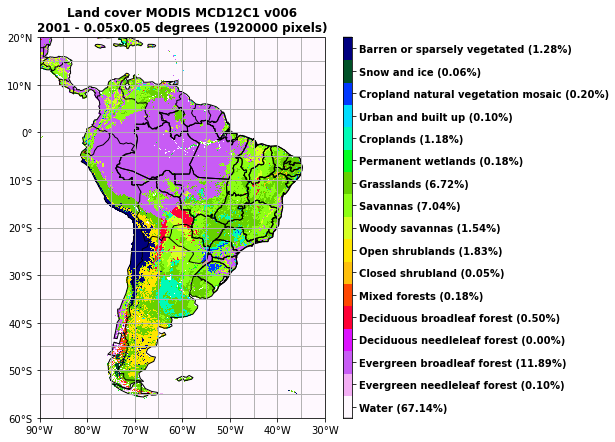

In [11]:
%%time

# Grid for one map.
axgr = cdlearn.maps.south_america(
    figsize=(14, 7),
    nrows_ncols=(1, 1),
    titles=[
        f"Land cover MODIS MCD12C1 v006\n2001 - 0.05x0.05 degrees ({total} pixels)"
    ]
)

# Plot mean results.
plotmap = DA_LC.plot(
    ax=axgr[0],
    vmin=int(0),
    vmax=int(16),
    levels=np.arange(0, 18, 1),
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)   

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(plotmap)
cb.cbar_axis.set_ticks(np.arange(0, 17, 1) + 0.5)

# Make colorbar y ticks as strings.
ylabels = [classes_dict[key] + str(" (%.2f%%)" %(percentages[key])) for key in range(17)]
_ = cb.cbar_axis.axes.yaxis.set_ticklabels(ylabels, weight="bold")

## Generate regridder file

In [12]:
# In accordance with GIMMS NDVI 3g original spatial grid.
NEW_GRID = xr.Dataset(
    coords={"lat": (["lat"], DS_NDVI.lat.values), 
            "lon": (["lon"], DS_NDVI.lon.values)}
)

# Show it.
print(NEW_GRID)

<xarray.Dataset>
Dimensions:  (lat: 960, lon: 720)
Coordinates:
  * lat      (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
  * lon      (lon) float64 -89.96 -89.88 -89.79 -89.71 ... -30.21 -30.13 -30.04
Data variables:
    *empty*


In [13]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DA_LC.to_dataset(),
    ds_out=NEW_GRID,
    method="nearest_s2d",
    periodic=False, # Not global data!
    filename="modis_to_gimms_regriddrer.nc",
    reuse_weights=True
)

# Do it.
DA_LC_REG = REGRIDDER(DA_LC)

# Sea mask.
DA_LC_REG = DA_LC_REG.assign_coords({"land_mask": DS_NDVI.land_mask})

print(DA_LC_REG)

Reuse existing file: modis_to_gimms_regriddrer.nc
<xarray.DataArray 'Majority_Land_Cover_Type_1' (lat: 960, lon: 720)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [8., 4., 2., ..., 0., 0., 0.],
       [4., 4., 2., ..., 0., 0., 0.],
       [4., 4., 2., ..., 0., 0., 0.]])
Coordinates:
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat        (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
    land_mask  (lat, lon) bool False False False False ... False False False
Attributes:
    regrid_method:  nearest_s2d
CPU times: user 52 ms, sys: 16 ms, total: 68 ms
Wall time: 69.8 ms


## Stack up regridded data and export it

In [14]:
%%time

# To be used in the unified xarray Dataset object.
DS_LC_REGs = []

print(">>> Original data coming from", MAIN_FOLDER + " folder:")

# Loop over annual data files.
for FILE_PATH in FILES_PATHS:
    
    print("* Regriding", os.path.basename(FILE_PATH) + " file:")
    
    # Read meta data.
    DS_LC = xr.open_dataset(FILE_PATH)
    
    # Major class occurrence (Num_IGBP_Classes=17).
    DA_LC = DS_LC.Majority_Land_Cover_Type_1
    
    # Load this data into memory as an xarray DataArray object.
    DA_LC = DA_LC.astype(np.int8) # Less memory.
    
    # Coordinates as usual.    
    DA_LC = DA_LC.rename({"YDim:MOD12C1": "lat", "XDim:MOD12C1": "lon"})
    DA_LC = DA_LC[::-1, :] # This is trick! It couldn't work otherwise when plotting data!
    DA_LC.coords["lat"] = ("lat", np.arange(-90, 90, 0.05)) # Ascending order.
    DA_LC.coords["lon"] = ("lon", np.arange(-180, 180, 0.05)) # Ascending order.

    # South America.
    DA_LC = DA_LC.sel(lat=slice(lati, latf), lon=slice(loni, lonf))
    
    # Regrid.
    DA_LC_REG = REGRIDDER(DA_LC)
    
    # Put results in a list.
    DS_LC_REGs.append(DA_LC_REG.to_dataset(name="land_class"))
    
# Make final result as a xarray Dataset object.
DS_LC_REG = xr.concat(objs=DS_LC_REGs, dim="time")

# Land-Sea mask.
DS_LC_REG = DS_LC_REG.assign_coords({"land_mask": DS_NDVI.land_mask})

# Yearly time step.
DS_LC_REG = DS_LC_REG.assign_coords(
    {"time": pd.date_range(start="2001", end="2019", freq="YS")}
)

# Probably unnecessary.
DS_LC_REG = DS_LC_REG.transpose("time", "lat", "lon")
DS_LC_REG = DS_LC_REG.astype(np.int)

# Show it.
print("\n>>> Final result:")
print(DS_LC_REG)

# Preprocessed file path.
ppdata_fp = "/work/sandroal/data_sets/MODIS/LAND_COVER/" + \
            "ppdata_land_cover_008x008_2001_2019_south_america.nc"

# Export preprocessed data.
DS_LC_REG.to_netcdf(path=ppdata_fp, mode="w")

>>> Original data coming from /work/sandroal/data_sets/MODIS/LAND_COVER/ folder:
* Regriding MCD12C1.A2001001.006.2018053185512.hdf file:
* Regriding MCD12C1.A2002001.006.2018053185530.hdf file:
* Regriding MCD12C1.A2003001.006.2018053185458.hdf file:
* Regriding MCD12C1.A2004001.006.2018053182130.hdf file:
* Regriding MCD12C1.A2005001.006.2018053183837.hdf file:
* Regriding MCD12C1.A2006001.006.2018053183950.hdf file:
* Regriding MCD12C1.A2007001.006.2018053184448.hdf file:
* Regriding MCD12C1.A2008001.006.2018053184623.hdf file:
* Regriding MCD12C1.A2009001.006.2018053184946.hdf file:
* Regriding MCD12C1.A2010001.006.2018053185051.hdf file:
* Regriding MCD12C1.A2011001.006.2018053185321.hdf file:
* Regriding MCD12C1.A2012001.006.2018053185406.hdf file:
* Regriding MCD12C1.A2013001.006.2018053185623.hdf file:
* Regriding MCD12C1.A2014001.006.2018053185556.hdf file:
* Regriding MCD12C1.A2015001.006.2018053185652.hdf file:
* Regriding MCD12C1.A2016001.006.2018324172410.hdf file:
* Regri

## Calculate pixel-wise area

In [15]:
%%time

# Grid sizes.
dlat = np.unique(np.diff(DS_LC_REG.lat))[0]
dlon = np.unique(np.diff(DS_LC_REG.lon))[0]
dy = dlat * cdlearn.utils.radius * np.pi / 180
dx = dlon * cdlearn.utils.radius * np.pi / 180 * \
            np.cos(np.pi /180 * xr.broadcast(DS_LC_REG.lat, DS_LC_REG.lon)[0])

# Area in m2 as an xarray Dataset object.
DS_AREA = np.abs(dx * dy).to_dataset(name="area")
DS_AREA = DS_AREA.assign_attrs({"units": "m2"})

# Land-se mask.
DS_AREA = DS_AREA.assign_coords({"land_mask": DS_NDVI.land_mask})

# Show it.
print(DS_AREA)

<xarray.Dataset>
Dimensions:    (lat: 960, lon: 720)
Coordinates:
  * lat        (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
    land_mask  (lat, lon) bool False False False False ... False False False
Data variables:
    area       (lat, lon) float64 4.308e+07 4.308e+07 ... 8.089e+07 8.089e+07
Attributes:
    units:    m2


CPU times: user 368 ms, sys: 20 ms, total: 388 ms
Wall time: 386 ms


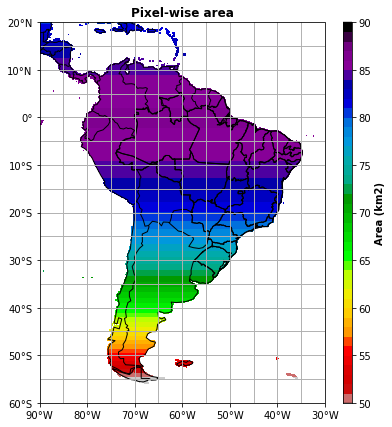

In [16]:
%%time

# Grid for one map.
axgr = cdlearn.maps.south_america(
    figsize=(14, 7),
    nrows_ncols=(1, 1),
    titles=["Pixel-wise area"]
)

# Plot area in km2.
plotmap = (DS_AREA.area.where(DS_AREA.land_mask==True) / 1e6).plot(
    ax=axgr[0],
    vmin=50,
    vmax=90,
    levels=np.arange(50, 90 + 1, 1),
    cmap=plt.cm.nipy_spectral_r,
    add_colorbar=False,
    add_labels=False
)   

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(plotmap)
cb.cbar_axis.set_ticks(np.arange(50, 90 + 5, 5))
_ = cb.set_label_text("Area (km2)", weight="bold")

## Time evolution of land classes

In [17]:
# My own color map.
base_colors = np.zeros(shape=(17, 4))
base_colors[0, :] = (1, 1, 1, 1)   
base_colors[1, :] = (255/255, 140/255, 26/255, 1)
base_colors[2, :] = (0, 0.30, 0, 1)  
base_colors[3, :] = (128/255, 64/255, 26/255, 1)
base_colors[4, :] = (26/255, 1, 1, 1)
base_colors[5, :] = (0.90, 0.90, 0.90, 1)
base_colors[6, :] = (0.95161471, 0.68297794, 0.9581098 , 1)   
base_colors[7, :] = (0.78717191, 0.36396903, 0.96170838, 1)
base_colors[8, :] = (0.75, 0.75, 0, 1)  
base_colors[9, :] = (1, 1, 0, 1)        
base_colors[10, :] = (204/255, 0, 102/255, 1)
base_colors[11, :] = (0, 0, 1, 1)
base_colors[12, :] = (0, 0.60, 0, 1)    
base_colors[13, :] = (1, 0, 0, 1)
base_colors[14, :] = (0, 0.90, 0, 1)    
base_colors[15, :] = (0, 0, 0.40, 1)    
base_colors[16, :] = (0.75, 0.75, 0.75, 1)
cmap_alex = ListedColormap(base_colors)

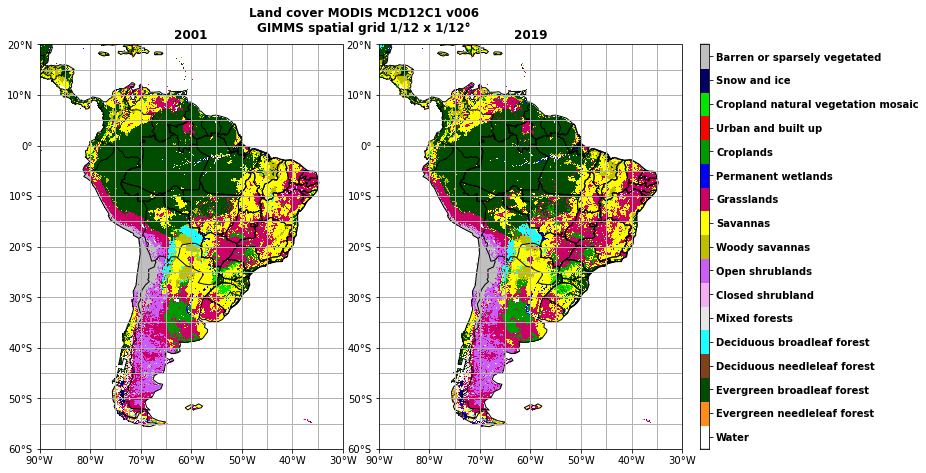

In [18]:
# Maps.
axgr = cdlearn.maps.south_america(
    figsize=(12, 12), 
    nrows_ncols=(1, 2),
    axes_pad=0.50,
    suptitle="Land cover MODIS MCD12C1 v006\nGIMMS spatial grid 1/12 x 1/12°",    
    suptitle_y=0.78,
    titles=["2001", "2019"],
    cbar_mode="single",
    cbar_location="right"
)

# Plot 2001 results.
plotmap = DS_LC_REG.land_class.isel(time=0).plot(
    ax=axgr[0],
    vmin=int(0),
    vmax=int(16),
    levels=np.arange(0, 18, 1),
    cmap=cmap_alex,
    add_colorbar=False,
    add_labels=False
)   

# Plot 2019 results.
plotmap = DS_LC_REG.land_class.isel(time=-1).plot(
    ax=axgr[1],
    vmin=int(0),
    vmax=int(16),
    levels=np.arange(0, 18, 1),
    cmap=cmap_alex,
    add_colorbar=False,
    add_labels=False
)  

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(plotmap)
cb.cbar_axis.set_ticks(np.arange(0, 17, 1) + 0.5)

# Make colorbar y ticks as strings.
ylabels = [classes_dict[key] for key in range(17)]
_ = cb.cbar_axis.axes.yaxis.set_ticklabels(ylabels, weight="bold")

# Save figures.
plt.savefig(
    FIG_FOLDER + "land_cover_igbp_modis_2001_2019.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

In [19]:
%%time

# Results as a pandas DataFrame object. Count pixel occurrences for each class.
df_land_classes = pd.DataFrame(
    data=np.zeros(shape=(DS_LC_REG.time.size, 18)),
    columns=np.arange(-1, 17)
)

for index, YEAR in enumerate([str(year) for year in DS_LC_REG.time.dt.year.values]):
    
    # Only land pixels counts.
    data = DS_LC_REG.land_class.where(DS_LC_REG.land_mask==True, other=-1).\
                     sel(time=YEAR).values.flatten()
        
    # Save results.
    col_nums, counts = np.unique(data, return_counts=True)
    df_land_classes.loc[index, col_nums] = counts

# Final form for pandas DataFrame object.
df_land_classes.index = DS_LC_REG.time.dt.year.values

# Show it.
df_land_classes.head()

CPU times: user 648 ms, sys: 416 ms, total: 1.06 s
Wall time: 1.06 s


,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2001,455766.0,8407.0,708.0,82141.0,0.0,3491.0,1229.0,366.0,12631.0,10609.0,48682.0,46403.0,1232.0,8103.0,713.0,1423.0,411.0,8885.0
2002,455766.0,8453.0,634.0,81912.0,0.0,3639.0,1271.0,364.0,12656.0,10661.0,48387.0,46706.0,1214.0,8116.0,713.0,1407.0,386.0,8915.0
2003,455766.0,8477.0,555.0,81337.0,0.0,3823.0,1318.0,363.0,12728.0,10816.0,48065.0,47107.0,1179.0,8214.0,709.0,1435.0,382.0,8926.0
2004,455766.0,8467.0,523.0,80752.0,0.0,4067.0,1313.0,366.0,12769.0,10963.0,47915.0,47297.0,1178.0,8340.0,712.0,1449.0,390.0,8933.0
2005,455766.0,8466.0,502.0,80251.0,0.0,4176.0,1309.0,362.0,12894.0,11122.0,47856.0,47398.0,1175.0,8429.0,718.0,1428.0,420.0,8928.0


In [20]:
# Number of land pixels.
n_land = df_land_classes.iloc[0, 1:].sum()

# Percentages.
df_percentages = (df_land_classes.iloc[:, 1:] / n_land * 100).copy(deep=True)

# Show it
df_percentages.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2001,3.570852,0.300721,34.889183,0.0,1.482793,0.522015,0.155458,5.364986,4.506146,20.677557,19.709558,0.523289,3.441729,0.302845,0.604416,0.174571,3.773881
2002,3.590391,0.269290,34.791916,0.0,1.545656,0.539854,0.154608,5.375604,4.528233,20.552257,19.838256,0.515643,3.447251,0.302845,0.597620,0.163953,3.786624
2003,3.600584,0.235735,34.547686,0.0,1.623810,0.559817,0.154183,5.406186,4.594069,20.415488,20.008580,0.500777,3.488876,0.301146,0.609513,0.162254,3.791296
2004,3.596337,0.222143,34.299209,0.0,1.727448,0.557693,0.155458,5.423601,4.656507,20.351776,20.089282,0.500353,3.542394,0.302420,0.615459,0.165652,3.794269
2005,3.595912,0.213223,34.086411,0.0,1.773746,0.555994,0.153759,5.476694,4.724042,20.326716,20.132181,0.499078,3.580197,0.304969,0.606539,0.178394,3.792146


CPU times: user 2.41 s, sys: 288 ms, total: 2.7 s
Wall time: 2.71 s


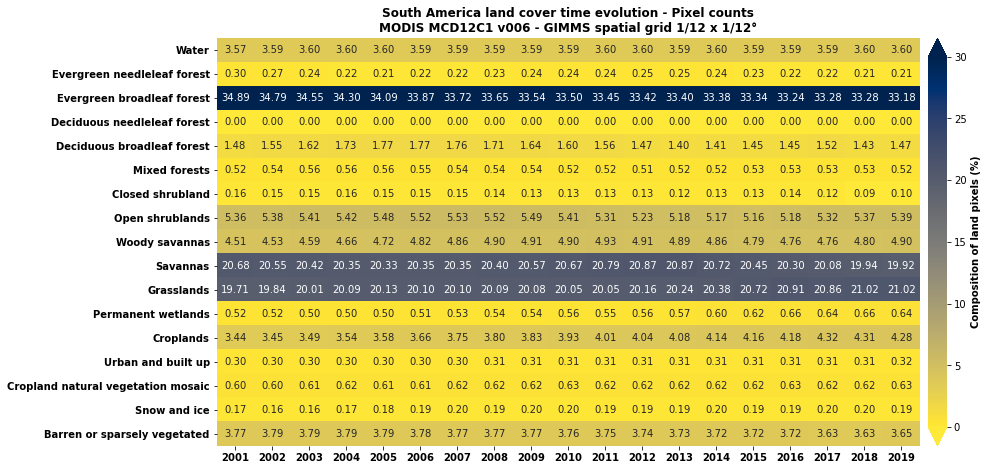

In [21]:
%%time

# Make figure.
plt.figure(figsize=(15, 7.5))
ax = sns.heatmap(
    data=df_percentages.T,
    cmap=plt.cm.cividis_r,
    robust=True,
    annot=True,
    fmt=".2f",
    vmin=0,
    vmax=30,
    yticklabels=[classes_dict[key] for key in range(17)],
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_title("South America land cover time evolution - Pixel counts" + \
             "\nMODIS MCD12C1 v006 - GIMMS spatial grid 1/12 x 1/12°", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Composition of land pixels (%)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "land_classes_heatmap.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

In [22]:
# Cumbersome calculation.
data = (df_percentages.values - df_percentages.iloc[0, :].values.reshape((1, -1))) / \
        df_percentages.iloc[0, :].values.reshape((1, -1)) * 100
df_percentages_rel = pd.DataFrame(
    data=data, 
    columns=df_percentages.columns,
    index=df_percentages.index
)

CPU times: user 2.34 s, sys: 244 ms, total: 2.58 s
Wall time: 2.59 s


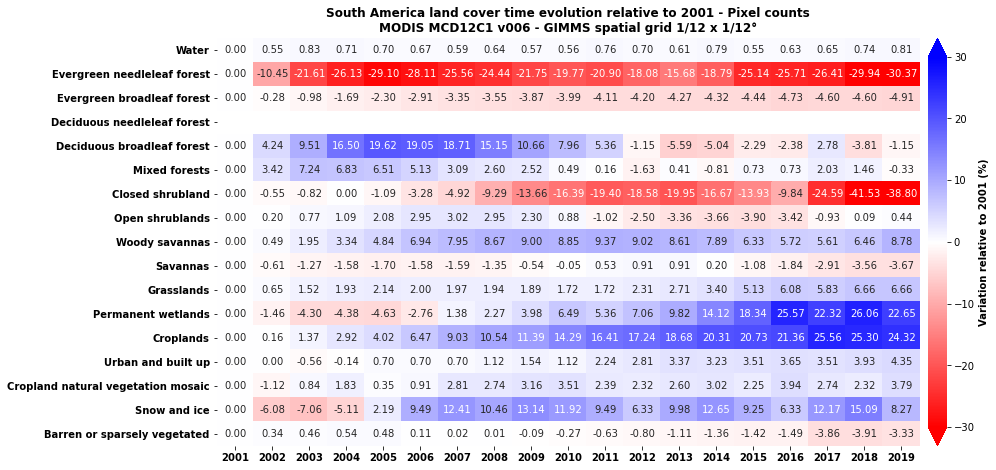

In [23]:
%%time

# Make figure.
plt.figure(figsize=(15, 7.5))
ax = sns.heatmap(
    data=df_percentages_rel.T,
    cmap=plt.cm.bwr_r,
    robust=True,
    annot=True,
    fmt=".2f",
    vmin=-30,
    vmax=30,
    yticklabels=[classes_dict[key] for key in range(17)],
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_title("South America land cover time evolution relative to 2001 - Pixel counts" + \
             "\nMODIS MCD12C1 v006 - GIMMS spatial grid 1/12 x 1/12°", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Variation relative to 2001 (%)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "land_classes_heatmap2.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

In [24]:
%%time

# Results as a pandas DataFrame object. Count total area (im m2) for each class.
df_areas = pd.DataFrame(
    data=np.zeros(shape=(DS_LC_REG.time.size, 18)),
    columns=np.arange(-1, 17)
)

# Loop over years.
for index, YEAR in enumerate([str(year) for year in DS_LC_REG.time.dt.year.values]):
    
    # Loop over land classes.
    for land_class in np.unique(DS_LC_REG.land_class):
  
        # Number of land class.
        data = DS_LC_REG.land_class.\
                         sel(time=YEAR).\
                         where(DS_LC_REG.land_mask==True).\
                         where(DS_LC_REG.land_class==land_class)
        
        # Calculate total area of this class.
        area = DS_AREA.area.\
                       where(DS_AREA.land_mask==True).\
                       where(~np.isnan(data.isel(time=0))).\
                       values
            
        # Save results.
        df_areas.loc[index, land_class] = np.nansum(area)
        
# Final form for pandas DataFrame object.
df_areas.index = DS_LC_REG.time.dt.year.values

# Area of sea.
df_areas.iloc[:, 0] = np.nansum(DS_AREA.area.where(DS_AREA.land_mask==False).values)

# Show it.
df_areas.head()

CPU times: user 13.9 s, sys: 420 ms, total: 14.3 s
Wall time: 14.3 s


,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2001,3.259323e+13,6.174471e+11,4.021706e+10,6.965076e+12,0.0,2.776353e+11,7.542311e+10,3.063233e+10,8.668718e+11,8.653220e+11,3.956339e+12,3.591789e+12,9.341706e+10,6.150631e+11,5.604754e+10,1.110586e+11,2.340383e+10,6.839732e+11
2002,3.259323e+13,6.204257e+11,3.609336e+10,6.945624e+12,0.0,2.895279e+11,7.783580e+10,3.047203e+10,8.684509e+11,8.696620e+11,3.934612e+12,3.615652e+12,9.148257e+10,6.164318e+11,5.602036e+10,1.097326e+11,2.201489e+10,6.856784e+11
2003,3.259323e+13,6.219838e+11,3.179330e+10,6.898001e+12,0.0,3.042405e+11,8.062327e+10,3.033950e+10,8.735219e+11,8.827766e+11,3.908909e+12,3.648561e+12,8.856025e+10,6.243181e+11,5.569665e+10,1.118272e+11,2.178399e+10,6.867808e+11
2004,3.259323e+13,6.214541e+11,3.014283e+10,6.849209e+12,0.0,3.239157e+11,8.035078e+10,3.047972e+10,8.760702e+11,8.959588e+11,3.897429e+12,3.664027e+12,8.858307e+10,6.338983e+11,5.592360e+10,1.129692e+11,2.219964e+10,6.871052e+11
2005,3.259323e+13,6.216258e+11,2.901475e+10,6.806872e+12,0.0,3.326471e+11,8.006728e+10,3.010763e+10,8.847793e+11,9.108432e+11,3.891268e+12,3.674263e+12,8.852382e+10,6.414277e+11,5.640427e+10,1.111419e+11,2.395641e+10,6.867731e+11


In [25]:
# Cumbersome calculation.
data = (df_areas.values - df_areas.iloc[0, :].values.reshape((1, -1))) / \
        df_areas.iloc[0, :].values.reshape((1, -1)) * 100
df_areas_rel = pd.DataFrame(
    data=data, 
    columns=df_areas.columns,
    index=df_areas.index
)
df_areas_rel = df_areas_rel.iloc[:, 1:]

CPU times: user 2.42 s, sys: 272 ms, total: 2.69 s
Wall time: 2.7 s


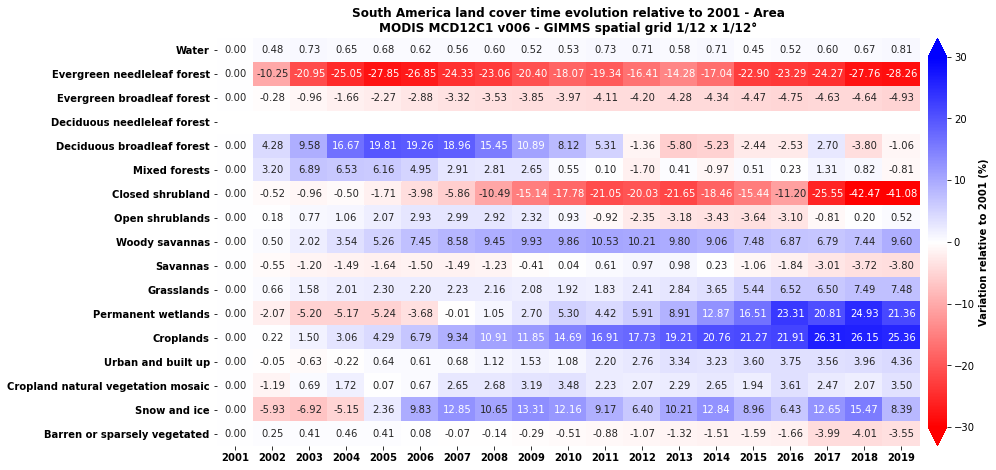

In [26]:
%%time

# Make figure.
plt.figure(figsize=(15, 7.5))
ax = sns.heatmap(
    data=df_areas_rel.T,
    cmap=plt.cm.bwr_r,
    robust=True,
    annot=True,
    fmt=".2f",
    vmin=-30,
    vmax=30,
    yticklabels=[classes_dict[key] for key in range(17)],
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_title("South America land cover time evolution relative to 2001 - Area" + \
             "\nMODIS MCD12C1 v006 - GIMMS spatial grid 1/12 x 1/12°", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Variation relative to 2001 (%)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "land_classes_heatmap3.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Pixels with change in time

In [27]:
# Count number of changing classes for each pixel.
mask_changes = DS_LC_REG.land_class.diff(dim="time").astype(bool).sum(dim="time")

In [28]:
# Dict with counts for changing pixels in land only.
changing_pixels_counts = {}
values, counts = np.unique( # -1 For sea pixels.
    mask_changes.where(mask_changes.land_mask==True, other=-1), return_counts=True
)

# Fill in this dictionary.
for value, count in zip(values, counts):
    changing_pixels_counts[value] = count

# Remove sea counts.    
_ = changing_pixels_counts.pop(-1)

# Show it.
print(">>> {Changes: Counts}:")
changing_pixels_counts

>>> {Changes: Counts}:


{0: 196598,
 1: 18609,
 2: 11190,
 3: 4764,
 4: 2397,
 5: 1063,
 6: 474,
 7: 202,
 8: 90,
 9: 31,
 10: 8,
 11: 6,
 12: 2}

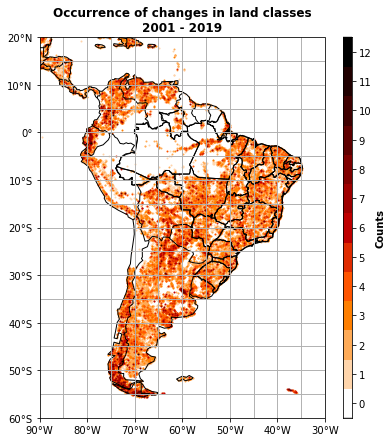

In [29]:
# Grid for one map.
axgr = cdlearn.maps.south_america(
    figsize=(14, 7),
    nrows_ncols=(1, 1),
    titles=[
        f"Occurrence of changes in land classes\n2001 - 2019"
    ],
)

# Plot mean results.
vmin = mask_changes.min().values; vmax = mask_changes.max().values
plotmap = mask_changes.where(mask_changes.land_mask==True).plot(
#     ax=axgr[0], Trick: It does not show colors on maps, but generate 'plotmap' variable
#                 for coolorbar!             
    vmin=vmin,
    vmax=vmax,
    levels=np.arange(vmin, vmax + 2, 1),
    cmap=plt.cm.gist_heat_r,
    add_colorbar=False,
    add_labels=False
)   

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(plotmap)
cb.set_label_text("Counts", weight="bold")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + 1, 1) + 0.5)
_ = cb.cbar_axis.set_ticklabels(np.arange(0, vmax + 1))

# Scatter plots for changing pixels.
counts_cp = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cmap = plt.get_cmap(name="gist_heat_r", lut=counts_cp.size)
colors = [cmap(fraction) for fraction in (counts_cp / counts_cp.size)]
DS_LATS, DS_LONS = xr.broadcast(mask_changes.lat, mask_changes.lon)

# Loop over counts.
for count_cp, c in zip(counts_cp, colors):

    axgr[0].scatter(
        DS_LONS.where(mask_changes==count_cp).where(mask_changes.land_mask==True).values.flatten(), 
        DS_LATS.where(mask_changes==count_cp).where(mask_changes.land_mask==True).values.flatten(),
        marker="o", color=c, s=1.0
    )

# Save figure. 
if save_fig:
    plt.savefig(
        FIG_FOLDER + "land_classes_changing_pixels.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )    

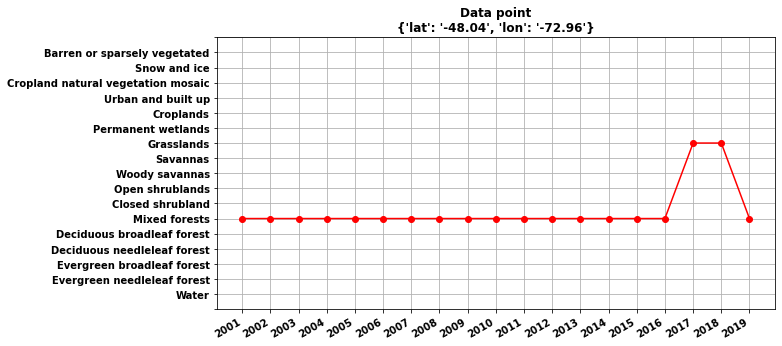

In [30]:
# Make figure.
plt.figure(figsize=(10, 5))

# Select some pixels.
lat = -48.0
lon = -73.0

# Plot time series.
data = DS_LC_REG.land_class.sel(lat=lat, lon=lon, method="nearest")
data.plot(ax=plt.gca(), marker="o", color="red")
selection = {}
selection["lat"] = "%.2f" %(data.lat.values)
selection["lon"] = "%.2f" %(data.lon.values)

# Adjustments.
plt.title("Data point\n" + str(selection), weight="bold")
plt.ylim((-1, 17))
plt.yticks(np.arange(-1, 18))
yticklabels = [None] + [classes_dict[key] for key in range(17)] + [None]
plt.gca().axes.set_yticklabels(yticklabels, weight="bold")
plt.ylabel(None)
plt.xlabel(None)
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label1.set_fontweight("bold")
    
# Save figure. 
if save_fig:
    plt.savefig(
        FIG_FOLDER + "land_classes_changing_pixel_time_series.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )       

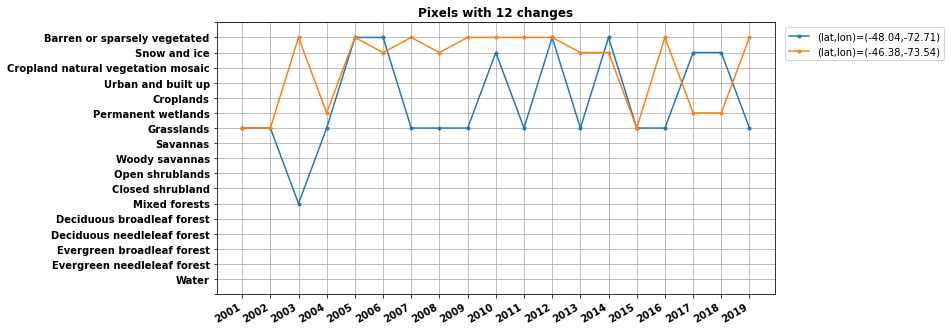

In [31]:
# Make figure.
plt.figure(figsize=(10, 5))

# All grid points with this counting in changes of classification.
count_cp = 12

# Extract coodinates for these points.
values = mask_changes.where(mask_changes==count_cp, drop=True).values.flatten()
lats = DS_LATS.where(mask_changes==count_cp, drop=True).values.flatten()
lons = DS_LONS.where(mask_changes==count_cp, drop=True).values.flatten() 
mask = ~np.isnan(values)
values = values[mask]
lats = lats[mask]
lons = lons[mask]

# Plot them.
for lat, lon in zip(lats, lons):
    data = DS_LC_REG.land_class.sel(lat=lat, lon=lon, method="nearest")
    data.plot(
        ax=plt.gca(), 
        marker="o", ms=3, 
        label="(lat,lon)=(%.2f,%.2f)" %(data.lat.values, data.lon.values)
    )

# Adjustments.    
plt.title(f"Pixels with {count_cp} changes", weight="bold")
plt.ylim((-1, 17))
plt.yticks(np.arange(-1, 18))
yticklabels = [None] + [classes_dict[key] for key in range(17)] + [None]
plt.gca().axes.set_yticklabels(yticklabels, weight="bold")
plt.ylabel(None)
plt.xlabel(None)
plt.grid()
plt.legend(bbox_to_anchor=(1.01, 1))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label1.set_fontweight("bold")
    
# Save figure. 
if save_fig:
    plt.savefig(
        FIG_FOLDER + "land_classes_changing_pixel_time_series2.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )       